# Neural Network - Perceptron Classifier

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import os
import sys
from keras.layers import Dense, Activation, BatchNormalization, InputLayer, Dropout
from keras.models import Sequential
from utils import *

sns.set()

plt.rc('legend',fontsize=13)
plt.rc('axes',labelsize=15)
plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

2022-09-17 15:16:33.779078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-17 15:16:33.779102: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
NUMBER_HIDDEN_NEURONS = 36

def get_model(feature_count, class_count, hidden_layer, use_batch_norm=True, optimizer='rmsprop', activation='sigmoid'):
	return_model = Sequential()
	return_model.add(InputLayer(input_shape=(feature_count,)))
	# return_model.add(Dropout(0.1))
	if use_batch_norm:
		return_model.add(BatchNormalization())
	for neurones in hidden_layer:
		return_model.add(Dense(neurones))
		return_model.add(Activation(activation))
		if use_batch_norm:
			return_model.add(BatchNormalization())
	# return_model.add(Dropout(0.1))
	return_model.add(Dense(class_count))
	return_model.add(Activation('softmax'))

	return_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

	# return_model.summary()

	return return_model

def perceptron(data_set, number_of_epoch, hidden_neurons=((NUMBER_HIDDEN_NEURONS,),),
			   use_batch_norm_values=(True,), optimizer_values=('rmsprop',),
			   activation_values=('sigmoid',), training_sizes=(-1,)):

	x_learn, y_learn, x_test, y_test = get_data(data_set=data_set,
												batch_format="keras")

	fit_dict = {}
	df = pd.DataFrame()
	for opt in optimizer_values:
		fit_dict[opt] = dict()
		for act in activation_values:
			fit_dict[opt][act] = dict()
			for use_batch_norm in use_batch_norm_values:
				fit_dict[opt][act][use_batch_norm] = dict()
				for layers in hidden_neurons:
					fit_dict[opt][act][use_batch_norm][layers] = dict()
					for train_limit in training_sizes:
						number_of_feature = len(x_learn[0])
						number_of_class = len(y_learn[0])
						model = get_model(number_of_feature, number_of_class, layers, use_batch_norm, opt, act)
						h = model.fit(x=np.array(x_learn[:train_limit]),
									  y=np.array(y_learn[:train_limit]),
									  batch_size=len(x_learn[:train_limit]),
									  epochs=number_of_epoch,
									  validation_data=(np.array(x_test),
													   np.array(y_test)),
									  verbose=0
									  )
						epoch = h.epoch
						h_values = h.history.values()
						values = np.array([epoch, ] + list(h_values))
						tmp = pd.DataFrame(data=values.T, columns=["epoch", ] + list(h.history.keys()))
						tmp = tmp.assign(use_batch_norm=pd.Series([use_batch_norm] * number_of_epoch))
						tmp = tmp.assign(optimizer=pd.Series([opt] * number_of_epoch))
						tmp = tmp.assign(activation=pd.Series([act] * number_of_epoch))
						tmp = tmp.assign(layers=pd.Series([str(layers)] * number_of_epoch))
						tmp = tmp.assign(train_size=pd.Series([str(train_limit)] * number_of_epoch))
						df = df.append(tmp)
						fit_dict[opt][act][use_batch_norm][layers][train_limit] = dict()
						for i, e in enumerate(epoch):
							fit_dict[opt][act][use_batch_norm][layers][train_limit][e] = dict()
							for k, v in h.history.items():
								fit_dict[opt][act][use_batch_norm][layers][train_limit][e][k] = v[i]
	fit_dict_index = {'optimizer': 0,
					  'activation': 1,
					  'use_batch_norm': 2,
					  'layers': 3,
					  'train_limit': 4,
					  'epoch': 5,
					  'score_type': 6}
	return df, fit_dict, fit_dict_index

def run(data_set_name):
	if data_set_name == "creditcard":
		dff, tt, tti = perceptron(data_set_name,
								  number_of_epoch=600,
								  hidden_neurons=((), (15,), (10,), (5,), (15, 5), (10, 5)),
								  use_batch_norm_values=(True, False),
								  optimizer_values=('rmsprop',),
								  activation_values=('sigmoid', 'relu', 'linear', 'selu'),
								  training_sizes=range(10000, 210000, 50000)
								  )
	elif data_set_name == "starcraft":
		dff, tt, tti = perceptron(data_set_name,
								  number_of_epoch=800,
								  hidden_neurons=((2, ),),
								  use_batch_norm_values=(True,),
								  optimizer_values=('rmsprop', 'adam'),
								  activation_values=('sigmoid', 'relu', 'selu'),
								  training_sizes=(-1,)
								  )
	else:
		raise ValueError("unknow dataset:", data_set_name)
	if not os.path.exists("../stats"):
		os.makedirs("../stats")
	dff.to_csv(path_or_buf="../stats/per_test_" + data_set_name + ".csv")
	dff.to_csv(path_or_buf="../stats/per_" + data_set_name + ".csv")
	with open("../stats/per_" + data_set_name + "_dict.pikle", 'wb') as handle:
		pickle.dump(tt, handle, protocol=pickle.HIGHEST_PROTOCOL)
	with open("../stats/per_" + data_set_name + "_dict_indexes.pikle", 'wb') as handle:
		pickle.dump(tti, handle, protocol=pickle.HIGHEST_PROTOCOL)

# run("creditcard")
# run("starcraft")

## Creditcard Dataset

In [3]:
data_set_name = "creditcard"
with open("../stats/per_" + data_set_name + "_dict.pikle", 'rb') as handle:
	dd = pickle.load(handle)
with open("../stats/per_" + data_set_name + "_dict_indexes.pikle", 'rb') as handle:
	ddi = pickle.load(handle)

In [4]:
print(ddi)

{'optimizer': 0, 'activation': 1, 'use_batch_norm': 2, 'layers': 3, 'train_limit': 4, 'epoch': 5, 'score_type': 6}


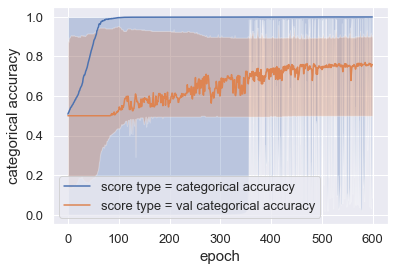

In [5]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'score_type'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy', 'categorical_accuracy'])]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+"_full.png")
plt.show()

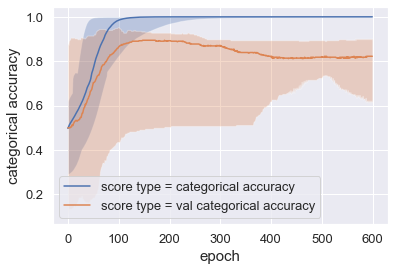

In [6]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'score_type'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy', 'categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

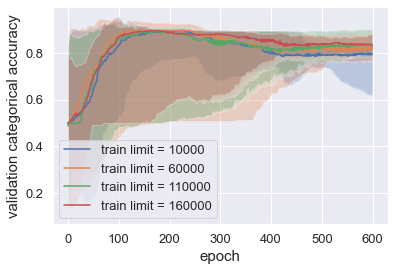

In [7]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'train_limit'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

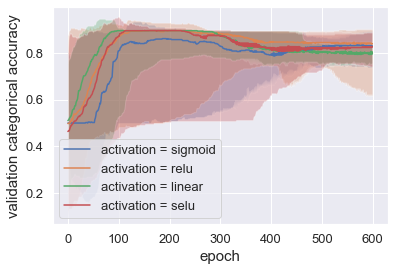

In [8]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'activation'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

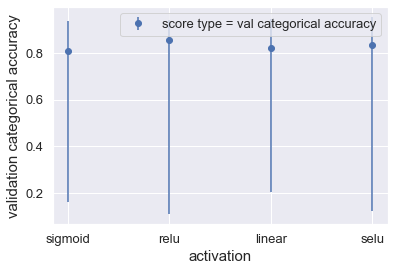

In [9]:
x_arg_name = 'activation'
y_arg_name = 'score_type'
z_arg_name = 'score_type'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
    plt.errorbar(
		d.get(x_arg_name),d.get('median'), 
		yerr=[d.get('median') - d.get('min'),d.get('max') - d.get('median')],
		fmt='o',
		label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' ')
	)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

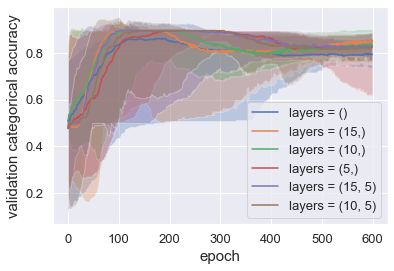

In [10]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'layers'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

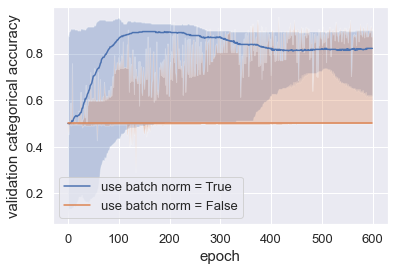

In [11]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'use_batch_norm'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy'])]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

## Starcraft Dataset

In [12]:
data_set_name = "starcraft"
with open("../stats/per_" + data_set_name + "_dict.pikle", 'rb') as handle:
    dd = pickle.load(handle)
with open("../stats/per_" + data_set_name + "_dict_indexes.pikle", 'rb') as handle:
    ddi = pickle.load(handle)

In [13]:
print(ddi)

{'optimizer': 0, 'activation': 1, 'use_batch_norm': 2, 'layers': 3, 'train_limit': 4, 'epoch': 5, 'score_type': 6}


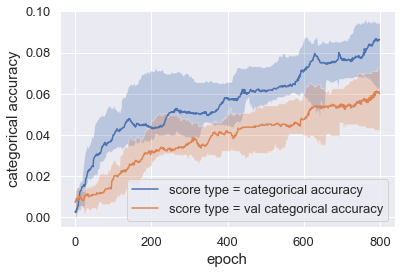

In [14]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'score_type'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy', 'categorical_accuracy'])]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+"_full.png")
plt.show()

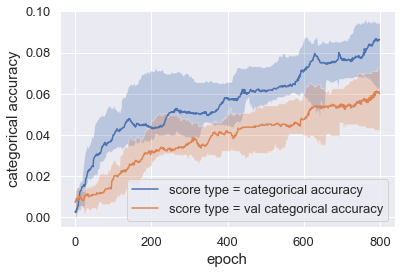

In [15]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'score_type'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy', 'categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

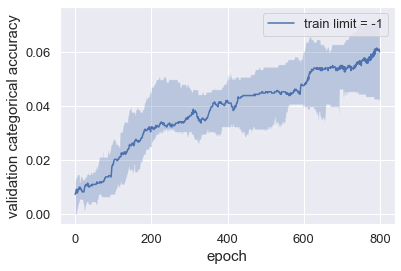

In [16]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'train_limit'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

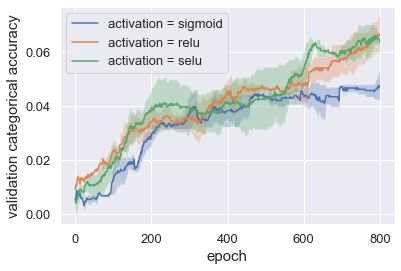

In [17]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'activation'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

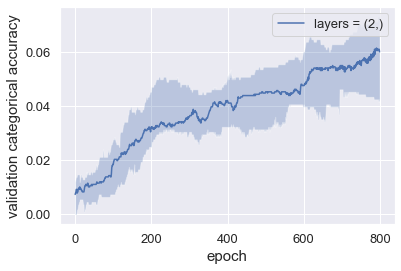

In [18]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'layers'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

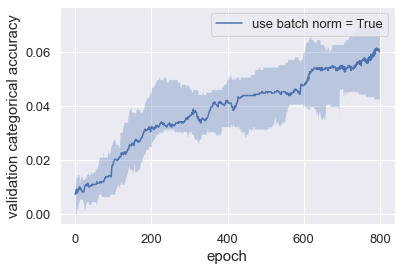

In [19]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'use_batch_norm'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy'])]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

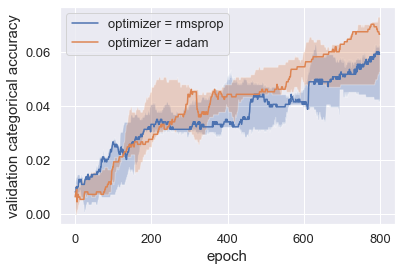

In [20]:
x_arg_name = 'epoch'
y_arg_name = 'score_type'
z_arg_name = 'optimizer'

x_arg_id = ddi[x_arg_name]
y_arg_id = ddi[y_arg_name]
z_arg_id = ddi[z_arg_name]

cd = consolidate_dict_data(
	dd, consolidate_argx=x_arg_id, argx_name=x_arg_name,
	consolidate_argy=y_arg_id, argy_name=y_arg_name,
	consolidate_argz=z_arg_id,
	filters=[(ddi['score_type'], ['val_categorical_accuracy']), (ddi['use_batch_norm'], True)]
)
plt.figure()
for a, d in cd.items():
	plt.plot(d.get(x_arg_name),d.get('median'), label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
	plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel('validation categorical accuracy')
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
plt.savefig("../graphics/per_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()